## Sentiment Analysis

### Business Problem

- This analysis will aim to build a model that can rate the sentiment of a tweet based on its content.
### Objectives

- To build a multimodal classifier that will accurately classify tweets into positive, negative and neutral

## Importing Relevant Libraries


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

### Importing the Dataset

In [7]:
# import os
# print(os.getcwd())
# os.chdir('c:/Users/Mzii/Downloads/Documents/Moringa/Projects/phase_4/phase_4_project')

In [8]:
# Set display options to show all rows and increase the column width
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Read data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [9]:
# Checking the first five rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [10]:
# Simplifying the column names

df.columns = ['tweet','brand','emotion']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9092 non-null   object
 1   brand    3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Changing column names enhances the dataset's readability, clarity, and user-friendliness. It contributes to smoother data analysis and facilitates sharing insights, as the new names accurately represent the content of the columns.

The dataset contains a total of 9,093 tweets, with nearly all entries having text data. However, only 3,291 entries specify a brand or product, which highlights that many tweets do not directly mention a particular brand. Despite this, each tweet is associated with an emotion, either positive or negative, which helps to understand the sentiment being conveyed.

## Data Cleaning

### Lowercase All the Characters


In [11]:
# lowercase all characters
df['tweet'] = df['tweet'].str.lower()
df['brand'] = df['brand'].str.lower()
df['emotion'] = df['emotion'].str.lower()

In [12]:
df.head()


,tweet,brand,emotion
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iphone,negative emotion
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",ipad or iphone app,positive emotion
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,ipad,positive emotion
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,ipad or iphone app,negative emotion
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",google,positive emotion


### Cleaning of the Brand column

In [13]:
# Identify distribution of column
df['brand'].value_counts()

brand
ipad                               946
apple                              661
ipad or iphone app                 470
google                             430
iphone                             297
other google product or service    293
android app                         81
android                             78
other apple product or service      35
Name: count, dtype: int64

In [14]:
# Map product category to brand

product_mapping = {
    "ipad": "apple",
    "ipad or iphone app": "apple",
    "iphone": "apple",
    "other apple product or service": "apple",
    "other google product or service": "google",
    "android app": "google",
    "android": "google"
}

# Map the 'brand' column to 'brand' using the product mapping
df["brand"] = df["brand"].str.lower().map(product_mapping).fillna(df["brand"])

# Display value counts and info
print(df["brand"].value_counts())
print(df.info())



brand
apple     2409
google     882
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9092 non-null   object
 1   brand    3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None


### Analyzing the Distribution of Missing Values in Brand Column

In [15]:
print(df["brand"].isna().sum())
print(df["brand"].isna().mean())  # Proportion of missing data

5802
0.6380732431540745


### Imputing Missing Values in Brand Column

In [16]:
# Selecting the first 100 lines of 'tweet' column where 'brand' is NaN
column_a_subset = df[df['brand'].isna()]['tweet'].head(100)
column_a_subset

5           @teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd
6                                                                                                                                                    NaN
16                                                          holler gram for ipad on the itunes app store -  http://t.co/kfn3f5q (via @marc_is_ken) #sxsw
32                                                   attn: all  #sxsw frineds, @mention register for #gdgtlive  and see cobra iradar for android. {link}
33                                                                                                         anyone at  #sxsw want to sell their old ipad?
34                                                                         anyone at  #sxsw who bought the new ipad want to sell their older ipad to me?
35                                          at #sxsw.  oooh. rt @mention google to

It seems that there are words within the tweets that can help us identify the associated brand from the comments. We will create a list of keywords and map them to their respective brands to support our analysis.

In [17]:
# Assign 'apple' or 'google' to 'brand' based on keywords in 'tweet'
df["brand"] = np.where(df["tweet"].str.contains("iphone|ipad|apple|itunes", na=False), "apple",
                       np.where(df["tweet"].str.contains("android|google", na=False), "google", df["brand"]))


In [18]:
# Count "Apple" and "Google"
brand_counts = df["brand"].value_counts()

# Count NaN values
nan_count = df["brand"].isna().sum()

# Display counts
print("Counts for 'apple' and 'google':")
print(brand_counts)

print("\nCount for NaN values:")
print(nan_count)


Counts for 'apple' and 'google':
brand
apple     5606
google    2780
Name: count, dtype: int64

Count for NaN values:
707


In [19]:
# Filter tweets that do not contain any of the keywords
non_matching_tweets = df[df["brand"].isna()]

# Display the tweets that did not match any keyword
print(non_matching_tweets[["tweet"]])


                                                                                                                                                               tweet
6                                                                                                                                                                NaN
51                                  ûï@mention {link} &lt;-- help me forward this doc to all anonymous accounts, techies,&amp; ppl who can help us jam #libya #sxsw
52                                                                                   ÷¼ what? ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newtwitter
53                                                                      .@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw
66                                                                          at #sxsw? @mention / @mention wanna buy you a drink. 7pm at fado on 4th. {link} join us!
71        

In [20]:
# Dropping the rows that do not contain any of the key words

df = df[df["brand"].isin(["apple", "google"])]

# Reset the index 
df.reset_index(drop=True, inplace=True)


### Checking and Dropping Duplicates and Missing Values

In [21]:
print("Before removal: ", df.duplicated().value_counts())
df.drop_duplicates(inplace=True)
print("After removal: ",df.duplicated().value_counts())

Before removal:  False    8346
True       40
Name: count, dtype: int64
After removal:  False    8346
Name: count, dtype: int64


In [22]:
# Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8346 entries, 0 to 8385
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8346 non-null   object
 1   brand    8346 non-null   object
 2   emotion  8346 non-null   object
dtypes: object(3)
memory usage: 260.8+ KB


### Cleaning the emotion Column

In [23]:
df["emotion"].value_counts()

emotion
no emotion toward brand or product    4672
positive emotion                      2956
negative emotion                       568
i can't tell                           150
Name: count, dtype: int64

In [24]:
# Understanding the 'I can't tell' sentiments
unknown_emotion = df[df['emotion'] == "i can't tell"]
unknown_emotion.sample(50)

,tweet,brand,emotion
7953,#socialnetworks: #google noch heute mit #circles? #facebook-konkurrent! {link} via @mention und {link} #sxsw,google,i can't tell
2888,google's facebook-killer &quot;circles&quot; to be unveiled today at #sxsw? {link},google,i can't tell
3191,i am neither at #sxsw nor buying an ipad 2 today. i feel like my geek cred is basically gone.,apple,i can't tell
6208,"rt @mention the ipad 1 is so march 11, 2011 4:59pm pst. #sxsw",apple,i can't tell
3029,"&quot;google products need to be condensed&quot;, #merissa #mayor at #sxsw conference 2011 {link}",google,i can't tell
4397,always wanted this! rt @mention sound of my voice was shot exploiting apple &amp; best buy's 14-day return policy on imacs. brilliant. #sxsw,apple,i can't tell
1890,vai comeì¤ar a palestra do @mention ex-chief evangelist of apple #sxsw,apple,i can't tell
3815,barry diller interview at #sxsw was pretty high level. does not understand the daily on ipad. all company valuations are high.,apple,i can't tell
3588,the panelist from texas observer called the ipad a lean back device #sxsw #in #newsapp #i'mconfused,apple,i can't tell
580,catch 22û_ i mean ipad 2 at #sxsw : {link},apple,i can't tell


We decided to drop the 'I can't tell' because we wanted to classify the sentiments in 'positive' , 'negative' and 'neutral' as this will help us enhance the quality of our analysis.

In [25]:
# Drop the columns containing "I can't tell"
df = df[df['emotion'] != "i can't tell"]
df['emotion'].value_counts()

emotion
no emotion toward brand or product    4672
positive emotion                      2956
negative emotion                       568
Name: count, dtype: int64

In [26]:
# Emotions dictionary for mapping
emotions_dict = {
    "no emotion toward brand or product": "neutral",
    "positive emotion": "positive",
    "negative emotion": "negative"
}

# Map old labels to new ones and drop NaN values
df["emotion"] = df["emotion"].map(emotions_dict).dropna()

# Check distribution of emotions
emotion_distribution = df["emotion"].value_counts(normalize=True)

# Display results
print(f"Distribution of Emotions:\n{emotion_distribution}")


Distribution of Emotions:
emotion
neutral     0.570034
positive    0.360664
negative    0.069302
Name: proportion, dtype: float64


For the target variable, we can note that we have a class imbalance, so we will perform different oversampling or undersampling techniques after the train test split to avoid data leakage.

## Exploratory Data Analysis

### Univariate Analysis

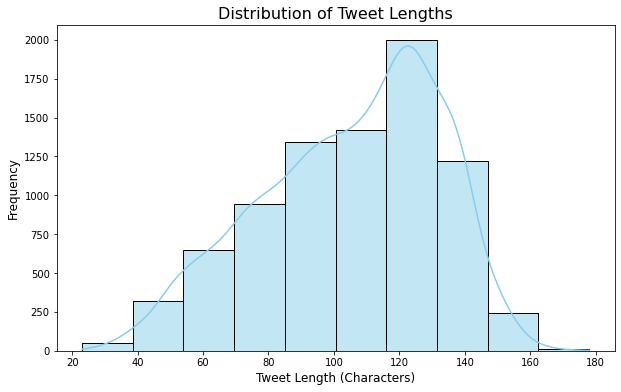

In [29]:
# distribution of text: sentense length analysis
plt.figure(figsize=(10, 6))

sns.histplot(df['tweet'].str.len(), bins=10, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of Tweet Lengths', fontsize=16)
plt.xlabel('Tweet Length (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

The distribution of the texts seem to be left skewed From above histogram, the tweets are comprised of around 29-160 characters.

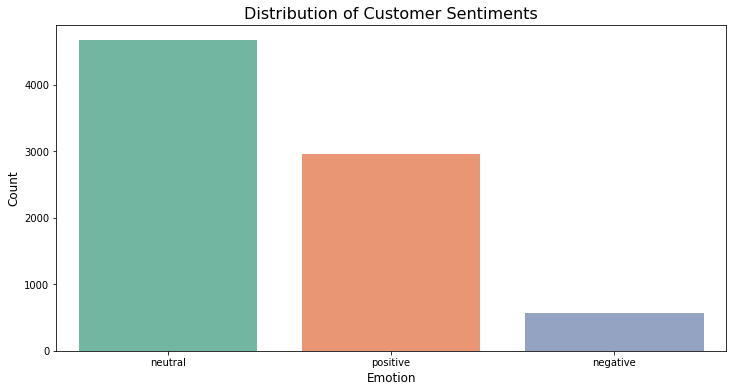

In [32]:
# Creating a countplot for sentiment distribution
plt.figure(figsize=(12, 6))

sns.countplot(x='emotion', data=df, palette='Set2', order=df['emotion'].value_counts().index)

plt.title('Distribution of Customer Sentiments', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

### Bivariate Analysis


### Sentiment Vs. Brand Analysis
This analysis examines how sentiment (positive, negative, neutral) is distributed across the two brands, specifically Apple and Google, as mentioned in the tweets. By doing so, we can gain insights into customer perceptions and attitudes toward each brand. This will help understand how each brand is viewed by its users in terms of sentiment.

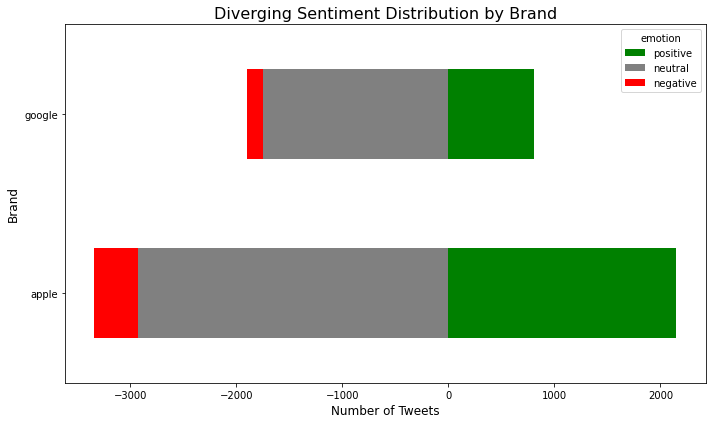

In [40]:

df_grouped = df.groupby(['brand', 'emotion']).size().unstack(fill_value=0)

df_grouped['positive'] = df_grouped['positive'] * 1  
df_grouped['neutral'] = df_grouped['neutral'] * -1   
df_grouped['negative'] = df_grouped['negative'] * -1  

df_grouped[['positive', 'neutral', 'negative']].plot(kind='barh', stacked=True, color=['green', 'gray', 'red'], figsize=(10, 6))

plt.title('Diverging Sentiment Distribution by Brand', fontsize=16)
plt.xlabel('Number of Tweets', fontsize=12)
plt.ylabel('Brand', fontsize=12)

plt.tight_layout()
plt.show()


Mentions of Apple products in the tweets show more extreme opinions, with both stronger positive and negative feelings compared to Google. In contrast, tweets about Google tend to have a more balanced and neutral tone. This suggests that Apple’s products may provoke stronger emotional responses, whether positive or negative, from users.

### Sentiment Vs. Tweet Length

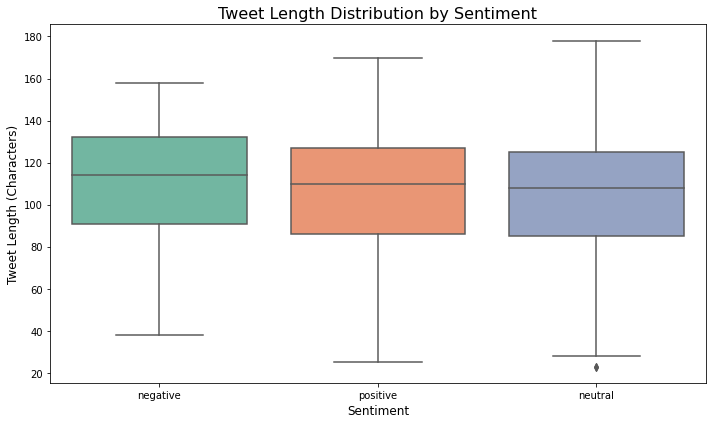

In [41]:

# Plotting a boxplot to visualize tweet length by sentiment
df['tweet_length'] = df['tweet'].str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='tweet_length', data=df, palette="Set2")

plt.title('Tweet Length Distribution by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Tweet Length (Characters)', fontsize=12)

plt.tight_layout()
plt.show()


From the box plots, we notice that most of the tweets whose lengths are longer hold negative sentiments. Also, the margine between the three sentiments is not too far apart. Therefore, it is safe to say that the length of the tweets is not enough to conclude on the customers' sentiments